# Propagation Project

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib

### Figures Management

In [2]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 14,
    'toolbar': 'None',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'legend.fancybox': False,
    'legend.shadow': False
})

## 1. GEO to LEO

$$ P(A > A_{th}) = \sum P(A > A_{th} | \theta_i) P(\theta_i) $$

csv headers for RAPIDS data:

0. Site number	
1. Satellite number	 
2. Frequency (GHz)	 
3. Elevation angle (deg)	 
4. Elevation probability ()	 
5. Time exceeded (%)	 
6. att_comb (dB)


In [3]:
# load the RAPIDS data.

aus_37_5_50 = np.genfromtxt("./data/37_austria_5_50/output/ascii/attenuation_total.csv", delimiter=",", skip_header=7, filling_values=0)
aus_37_55_90 = np.genfromtxt("./data/37_austria_55_90/output/ascii/attenuation_total.csv", delimiter=",", skip_header=7, filling_values=0)
nor_37_5_50 = np.genfromtxt("./data/37_norway_5_50/output/ascii/attenuation_total.csv", delimiter=",", skip_header=7, filling_values=0)
nor_37_55_90 = np.genfromtxt("./data/37_norway_55_90/output/ascii/attenuation_total.csv", delimiter=",", skip_header=7, filling_values=0)

aus_37 = np.concatenate((aus_37_5_50, aus_37_55_90))
nor_37 = np.concatenate((nor_37_5_50, nor_37_55_90))

In [4]:
# load the elevation probabilities.

p_theta_aus = np.array([1.26916122e-02, 8.47372406e-03, 5.69595155e-03, 
                        3.86117968e-03, 2.81951499e-03, 1.88600128e-03, 
                        1.44770521e-03, 1.01699868e-03, 7.91209792e-04, 
                        6.07163390e-04, 4.85730712e-04, 3.16863394e-04,
                        2.44762741e-04, 2.14404572e-04, 1.36611763e-04, 
                        6.45111101e-05, 2.08712415e-05, 0.00000000e+00])

p_theta_nor = np.array([0.0319405890623310, 0.0201635166903524, 0.0133177494730012,
                        0.0095400547585482, 0.0069406364969708, 0.0054151384806875,
                        0.0042767071252521, 0.0033811411256430, 0.0028593600877351,
                        0.0024817803548491, 0.0021819934312511, 0.0023584502913436,
                        0.0015122163171366, 0.0009638718809353, 0.0006318294022666,
                        0.0003472215634078, 0.0001157405211359, 0.0000000000000000])

# normalizing the pdfs

p_theta_aus /= np.sum(p_theta_aus)
p_theta_nor /= np.sum(p_theta_nor)

In [5]:
class LeoSatellite:
    
    def __init__(self, rapids_data, elevation_pdf, location):
        
        self.data = rapids_data
        self.p_el = elevation_pdf 
        self.location = location
        self.num_meas = self.meas_per_bin()
        self.num_bins = len(self.p_el)
        
        # x is att and y is time %
        self.interp_attenuations = [interp1d(
            self.data[i * self.num_meas:(i + 1) * self.num_meas, 6], 
            self.data[i * self.num_meas:(i + 1) * self.num_meas, 5]) for i in range(self.num_bins)]
        
        self.min_att = np.min(self.data[self.num_meas - 1::self.num_meas, 6]) # max of the lowest attenuations 
        self.max_att = np.min(self.data[0::self.num_meas, 6]) # min of the max attenuations
        
        
    def meas_per_bin(self): 
    
        measures = 0
        satellite_number = 1

        while(satellite_number == 1): 
                measures += 1
                satellite_number = self.data[measures, 1]    

        return measures
    
    
    def plot_cond_attenuations(self, num, save=False):
        
        att_pts = np.linspace(self.min_att, self.max_att, num=num)
        plt.figure()
        plt.title(f'Total attenuation in {self.location}')

        for i in range(self.num_bins):

            plt.semilogx(self.data[i * self.num_meas:(i + 1) * self.num_meas, 5],
                         self.data[i * self.num_meas:(i + 1) * self.num_meas, 6], color="k", linewidth=.5)
            # plt.semilogx(interp_attenuations[i](att_pts), att_pts)
            plt.axhline(self.min_att, color="k", linestyle="dashed", linewidth=.5)
            plt.axhline(self.max_att, color="k", linestyle="dashed", linewidth=.5)  

        plt.xlabel('Time percentage [\%]')
        plt.ylabel('Attenuation [dB]')
        
        if (save):
            plt.tight_layout()
            plt.savefig(f"my_plot_{self.location}.pdf")
        else: 
            plt.show()

    
    def plot_attenuation(self, num, save=False):
     
        att_pts = np.linspace(self.min_att, self.max_att, num=num)
        p_tot_att = np.zeros(num)

        for i in range(num):
            for j in range(self.num_bins):

                try:
                    p_tot_att[i] += self.interp_attenuations[j](att_pts[i]) * self.p_el[j]
                    
                except Exception as e:
                    # print(e)
                    p_tot_att[i] += 100 * self.p_el[j]

        plt.figure()      
        plt.semilogx(p_tot_att, att_pts)

        if (save):
            plt.tight_layout()
            plt.savefig("my_plot.pdf")
        else: 
            plt.show()

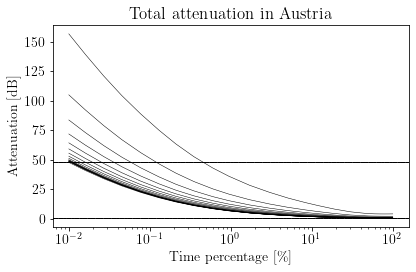

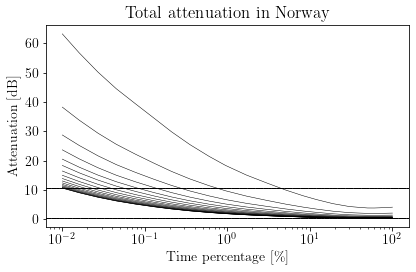

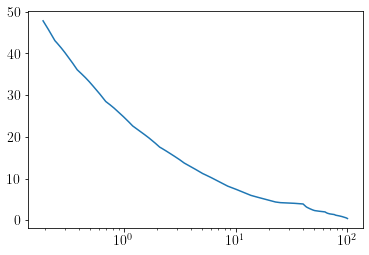

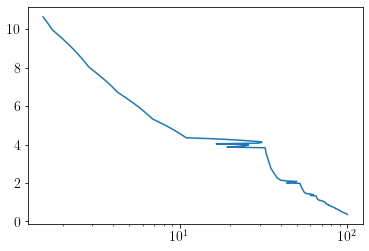

In [7]:
leo_sat_aus = LeoSatellite(aus_37, p_theta_aus, 'Austria') 
leo_sat_nor = LeoSatellite(nor_37, p_theta_nor, 'Norway') 

leo_sat_aus.plot_cond_attenuations(100, save=True)
leo_sat_nor.plot_cond_attenuations(100, save=True)

leo_sat_aus.plot_attenuation(300)
leo_sat_nor.plot_attenuation(300)